In [5]:
import torch
import torchvision
import transformers
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from PIL import Image

In [6]:
DATASET_DIR = Path('../../datasets')
VIVQA_GT_TRAIN_PATH = DATASET_DIR / 'ViVQA' / 'train.csv'
VIVQA_GT_TEST_PATH = DATASET_DIR / 'ViVQA' / 'test.csv'
VIVQA_IMG_TRAIN_DIR = DATASET_DIR / 'MS_COCO2014' / 'merge'


def visualize_sample(question, answer, img_path):
    img_pil = Image.open(img_path).convert('RGB')

    plt.imshow(img_pil)
    plt.axis('off')
    plt.title(f'Question: {question}?. Answer: {answer}')
    plt.show()

img_lst = os.listdir(VIVQA_IMG_TRAIN_DIR)

def get_data(df_path):
    df = pd.read_csv(df_path, index_col=0)
    questions = [] 
    answers = []
    img_paths = []
    for idx, row in df.iterrows():
        question = row['question']
        answer = row['answer']
        img_id = row['img_id']
        #question_type = row['type'] # 0: object, 1: color, 2: how many, 3: where
        img_path = VIVQA_IMG_TRAIN_DIR / f'{img_id:012}.jpg'

        questions.append(question)
        answers.append(answer)
        img_paths.append(img_path)

    return questions, img_paths, answers 


train_questions, train_img_paths, train_answers = get_data(VIVQA_GT_TRAIN_PATH)    
test_questions, test_img_paths, test_answers = get_data(VIVQA_GT_TEST_PATH)    

train_set_size = len(train_questions)
test_set_size = len(test_questions)

print(f'Number of train sample: {train_set_size}')
print(f'Number of test sample: {test_set_size}')


Number of train sample: 11999
Number of test sample: 3001


In [7]:
unique_labels = set(list(train_answers + test_answers))
idx2label = {idx: label for idx, label in enumerate(unique_labels)}
label2idx = {label: idx for idx, label in enumerate(unique_labels)}

In [4]:
# img_path = VIVQA_IMG_TRAIN_DIR / os.listdir(VIVQA_IMG_TRAIN_DIR)[222]
# img_pil = Image.open(img_path).convert('RGB')
# inputs = processor(img_pil, 'what is this about?', padding='max_length', truncation=True)
# inputs['input_ids']


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [29]:
from transformers import BlipProcessor, BlipForQuestionAnswering
from transformers import BitsAndBytesConfig
from peft import LoraConfig

quantize_config = BitsAndBytesConfig(
    load_in_8bit=True 
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_ID = 'Salesforce/blip-vqa-base'
processor = BlipProcessor.from_pretrained(MODEL_ID)
model = BlipForQuestionAnswering.from_pretrained(MODEL_ID, 
                                                device_map=device, 
                                                num_labels=len(idx2label), 
                                                id2label=idx2label, 
                                                label2id=label2idx)

# print(model.named_modules())

# lora_config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     lora_dropout=0.05,
#     bias=None,
#     target_modules=["q_proj", "k_proj"]
# )
# model.add_adapter(lora_config, adapter_name='adapter_1')

/home/server-ailab/miniconda3/envs/thangdd_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BlipForQuestionAnswering were not initialized from the model checkpoint at Salesforce/blip-vqa-base and are newly initialized: ['text_decoder.cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms

# img_transform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor()
# ])

class ViVQADataset(Dataset):
    def __init__(self, data_dir, data_mode, processor, img_transform=None, label_encoder=None):
        self.data_dir = data_dir
        if data_mode == 'train':
            self.data_path = data_dir / 'ViVQA' / 'train.csv'
        else:
            self.data_path = data_dir / 'ViVQA' / 'test.csv'
        self.img_transform = img_transform
        self.processor = processor
        self.label_encoder = label_encoder

        self.questions, self.img_paths, self.answers = self.get_data()

    def get_data(self):
        df = pd.read_csv(self.data_path, index_col=0)
        questions = [] 
        answers = []
        img_paths = []
        for idx, row in df.iterrows():
            question = row['question']
            answer = row['answer']
            img_id = row['img_id']
            #question_type = row['type'] # 0: object, 1: color, 2: how many, 3: where

            img_path = self.data_dir / 'MS_COCO2014' / 'merge' / f'{img_id:012}.jpg'

            questions.append(question)
            answers.append(answer)
            img_paths.append(img_path)


        return questions, img_paths, answers 

    def __getitem__(self, idx):
        questions = self.questions[idx]
        answers = self.answers[idx]
        img_paths = self.img_paths[idx]

        img_pil = Image.open(img_paths).convert('RGB')
        if self.img_transform:
            img_pil = self.img_transform(img_pil)

        inputs = self.processor(img_pil, questions, 
                           padding='max_length', 
                           truncation=True,
                           return_tensors='pt')
        label = [0 if idx != self.label_encoder[answers] else 1 for idx in range(len(self.label_encoder.keys()))]
        items = {k: v.squeeze() for k, v in inputs.items()}
        items['labels'] = torch.tensor(label)
        
        return items

    def __len__(self):
        return len(self.questions)
    
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 4
    
train_dataset = ViVQADataset(DATASET_DIR, 'train', 
                             processor, 
                             img_transform=None, 
                             label_encoder=label2idx)
val_dataset = ViVQADataset(DATASET_DIR, 'val', 
                           processor, 
                           img_transform=None, 
                           label_encoder=label2idx)
# train_loader = DataLoader(train_dataset,
#                           batch_size=TRAIN_BATCH_SIZE,
#                           shuffle=True)
# val_loader = DataLoader(val_dataset,
#                           batch_size=VAL_BATCH_SIZE,
#                           shuffle=False)

In [8]:
# LR = 5e-5
# EPOCHS = 20
# optimizer = torch.optim.Adam(model.parameters(),
#                              lr=LR)

# model.train()
# for epoch in range(EPOCHS):
#     train_loss_lst = []
#     for idx, batch in enumerate(train_loader):
#         input_ids = batch.pop('input_ids').to(device)
#         pixel_values = batch.pop('pixel_values').to(device)
#         attention_mask = batch.pop('attention_mask').to(device)
        
#         labels = batch.pop('labels').to(device)

#         outputs = model(input_ids=input_ids,
#                         pixel_values=pixel_values,
#                         attention_mask=attention_mask,
#                         labels=labels)

#         loss = outputs.loss

#         train_loss_lst.append(loss.item())

#         loss.backward()

#         optimizer.step()
#         optimizer.zero_grad()

#     train_loss = sum(train_loss_lst) / len(train_loss_lst)

#     print(f'EPOCH {epoch + 1}\tTrain loss: {train_loss}')

In [31]:
from transformers import TrainingArguments

REPO_ID = "thangduong0509/blip_vivqa_finetuned"

training_args = TrainingArguments(
    output_dir=REPO_ID,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    num_train_epochs=1,
    save_steps=200,
    logging_steps=100,
    learning_rate=5e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True
)

In [32]:
from transformers import Trainer
from transformers import DefaultDataCollator

import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    labels = np.armgax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

data_collator = DefaultDataCollator()

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

trainer.train() 

/home/server-ailab/miniconda3/envs/thangdd_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/1500 [00:00<?, ?it/s]

{'loss': 4.9046, 'grad_norm': 5.210002899169922, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.07}
{'loss': 0.0288, 'grad_norm': 0.04508095979690552, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.13}
{'loss': 0.0201, 'grad_norm': 0.023426752537488937, 'learning_rate': 4e-05, 'epoch': 0.2}
{'loss': 0.0199, 'grad_norm': 0.01528874784708023, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.27}
{'loss': 0.0198, 'grad_norm': 0.011294648982584476, 'learning_rate': 3.3333333333333335e-05, 'epoch': 0.33}
{'loss': 0.0197, 'grad_norm': 0.009121027775108814, 'learning_rate': 3e-05, 'epoch': 0.4}
{'loss': 0.0197, 'grad_norm': 0.0074499123729765415, 'learning_rate': 2.6666666666666667e-05, 'epoch': 0.47}
{'loss': 0.0196, 'grad_norm': 0.006660168524831533, 'learning_rate': 2.3333333333333336e-05, 'epoch': 0.53}
{'loss': 0.0196, 'grad_norm': 0.005653482861816883, 'learning_rate': 2e-05, 'epoch': 0.6}
{'loss': 0.0196, 'grad_norm': 0.007789940107613802, 'learning_rate': 1.6666666666666667

TrainOutput(global_step=1500, training_loss=0.34594474148750304, metrics={'train_runtime': 1273.52, 'train_samples_per_second': 9.422, 'train_steps_per_second': 1.178, 'train_loss': 0.34594474148750304, 'epoch': 1.0})

In [2]:
from transformers import pipeline

REPO_ID = "thangduong0509/blip_vivqa_finetuned"
pipe = pipeline("visual-question-answering", model=REPO_ID)

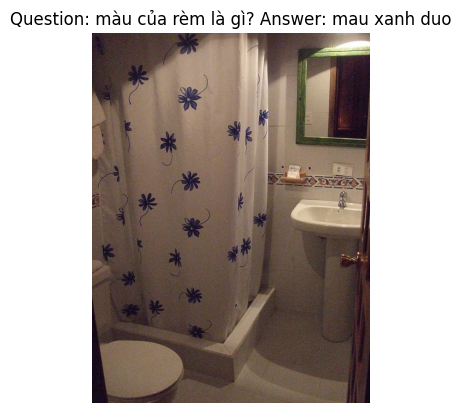

In [10]:
import matplotlib.pyplot as plt

from PIL import Image

image = Image.open(train_img_paths[10]).convert('RGB')
question = train_questions[10]
answer = pipe(image, question)[0]['answer']
plt.imshow(image)
plt.title(f'Question: {question}? Answer: {answer}')
plt.axis('off')
plt.show()

In [40]:
import gc

model.cpu()
del model, trainer
gc.collect()
torch.cuda.empty_cache()